## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization, Activation, Dropout
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], Regu_ratio = 1e-4, drp_ratio = 0.2):
    input_layer = Input(input_shape)   
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1),
                      kernel_regularizer = l1_l2(Regu_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1),
                      kernel_regularizer = l1_l2(Regu_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [11]:
def plt_model_result(result):
    color_bar = ["r", "g", "b", "y"]
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%4])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%4])
    plt.title("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%4])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%4])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [512, 1024]
MOMENTUM = 0.95
L1_L2_EXP = [1e-8, 1e-12]
Dropout_EXP = [0.2, 0.4]

In [8]:
results = {}
for batch_size, regularizer_ratio, drop_rate in itertools.product(BATCH_SIZE, L1_L2_EXP, Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE : %.0f, Regularizer : %.12f, Dropout : %.2f" % (batch_size,regularizer_ratio,drop_rate))
    model = build_mlp(input_shape = x_train.shape[1:], Regu_ratio = regularizer_ratio, drp_ratio = drop_rate)
    model.summary()
    optimizer = optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = batch_size, 
              validation_data = (x_test, y_test), 
              shuffle = True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'l1_l2:{str(regularizer_ratio)}, Dropout: {str(drop_rate)}, Batch_Size:{str(batch_size)}' 
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BATCH_SIZE : 512, Regularizer : 0.000000010000, Dropout : 0.20
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
________

Epoch 40/50
50000/50000 [==============================] - 16s 321us/step - loss: 1.7776 - acc: 0.3960 - val_loss: 1.7323 - val_acc: 0.4149
Epoch 41/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.7841 - acc: 0.3927 - val_loss: 1.7308 - val_acc: 0.4149
Epoch 42/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.7792 - acc: 0.3938 - val_loss: 1.8500 - val_acc: 0.3777
Epoch 43/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.7764 - acc: 0.3946 - val_loss: 1.7266 - val_acc: 0.4128
Epoch 44/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.7711 - acc: 0.4000 - val_loss: 1.8304 - val_acc: 0.3751
Epoch 45/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.7759 - acc: 0.3957 - val_loss: 1.8251 - val_acc: 0.3829
Epoch 46/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.7664 - acc: 0.3985 - val_loss: 1.7954 - val_acc: 0.3962
Epoch 47/50
50000/50

Epoch 36/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.9473 - acc: 0.3086 - val_loss: 1.9783 - val_acc: 0.2972
Epoch 37/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.9517 - acc: 0.3068 - val_loss: 1.9985 - val_acc: 0.2934
Epoch 38/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.9547 - acc: 0.3040 - val_loss: 2.2524 - val_acc: 0.2163
Epoch 39/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.9559 - acc: 0.3014 - val_loss: 2.0294 - val_acc: 0.2870
Epoch 40/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.9380 - acc: 0.3122 - val_loss: 1.9584 - val_acc: 0.3173
Epoch 41/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.9435 - acc: 0.3116 - val_loss: 2.0091 - val_acc: 0.3207
Epoch 42/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.9434 - acc: 0.3115 - val_loss: 2.0016 - val_acc: 0.3215
Epoch 43/50
50000/50

Epoch 32/50
50000/50000 [==============================] - 14s 270us/step - loss: 1.7809 - acc: 0.3931 - val_loss: 1.8093 - val_acc: 0.3819
Epoch 33/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.7862 - acc: 0.3900 - val_loss: 1.7857 - val_acc: 0.3770
Epoch 34/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.7731 - acc: 0.3952 - val_loss: 1.7430 - val_acc: 0.4045
Epoch 35/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.7796 - acc: 0.3924 - val_loss: 1.7884 - val_acc: 0.3858
Epoch 36/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.7863 - acc: 0.3898 - val_loss: 1.8502 - val_acc: 0.3794
Epoch 37/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.7859 - acc: 0.3878 - val_loss: 1.7339 - val_acc: 0.4148
Epoch 38/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.7751 - acc: 0.3928 - val_loss: 1.7702 - val_acc: 0.3936
Epoch 39/50
50000/50

Epoch 28/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.9531 - acc: 0.3035 - val_loss: 2.1192 - val_acc: 0.2701
Epoch 29/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.9498 - acc: 0.3054 - val_loss: 2.0246 - val_acc: 0.2920
Epoch 30/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.9543 - acc: 0.3027 - val_loss: 2.0699 - val_acc: 0.2808
Epoch 31/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.9517 - acc: 0.3018 - val_loss: 2.0039 - val_acc: 0.2921
Epoch 32/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.9519 - acc: 0.3019 - val_loss: 2.0621 - val_acc: 0.2943
Epoch 33/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.9488 - acc: 0.3031 - val_loss: 2.0647 - val_acc: 0.2954
Epoch 34/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.9506 - acc: 0.3029 - val_loss: 2.1579 - val_acc: 0.2547
Epoch 35/50
50000/50

Epoch 24/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.7332 - acc: 0.4148 - val_loss: 1.6703 - val_acc: 0.4370
Epoch 25/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.7298 - acc: 0.4179 - val_loss: 1.7836 - val_acc: 0.4092
Epoch 26/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.7289 - acc: 0.4169 - val_loss: 1.7147 - val_acc: 0.4291
Epoch 27/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.7273 - acc: 0.4213 - val_loss: 1.6951 - val_acc: 0.4421
Epoch 28/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.7308 - acc: 0.4177 - val_loss: 1.7084 - val_acc: 0.4167
Epoch 29/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.7310 - acc: 0.4182 - val_loss: 1.7164 - val_acc: 0.4207
Epoch 30/50
50000/50000 [==============================] - 12s 246us/step - loss: 1.7238 - acc: 0.4195 - val_loss: 1.6790 - val_acc: 0.4330
Epoch 31/50
50000/50

Epoch 20/50
50000/50000 [==============================] - 12s 250us/step - loss: 1.9123 - acc: 0.3365 - val_loss: 2.0108 - val_acc: 0.3098
Epoch 21/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.9150 - acc: 0.3361 - val_loss: 1.9184 - val_acc: 0.3653
Epoch 22/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.9285 - acc: 0.3286 - val_loss: 1.9656 - val_acc: 0.3047
Epoch 23/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.9230 - acc: 0.3311 - val_loss: 1.9425 - val_acc: 0.3449
Epoch 24/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.9089 - acc: 0.3352 - val_loss: 1.9317 - val_acc: 0.3555
Epoch 25/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.9025 - acc: 0.3354 - val_loss: 1.9412 - val_acc: 0.3201
Epoch 26/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.8954 - acc: 0.3340 - val_loss: 2.0314 - val_acc: 0.2997
Epoch 27/50
50000/50

Experiment with BATCH_SIZE : 1024, Regularizer : 0.000000000001, Dropout : 0.40
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
______________________________________________________________

Epoch 47/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.8869 - acc: 0.3330 - val_loss: 1.9582 - val_acc: 0.3501
Epoch 48/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.8916 - acc: 0.3350 - val_loss: 1.9245 - val_acc: 0.3477
Epoch 49/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.8881 - acc: 0.3355 - val_loss: 1.8543 - val_acc: 0.3818
Epoch 50/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.8915 - acc: 0.3350 - val_loss: 1.9720 - val_acc: 0.3218


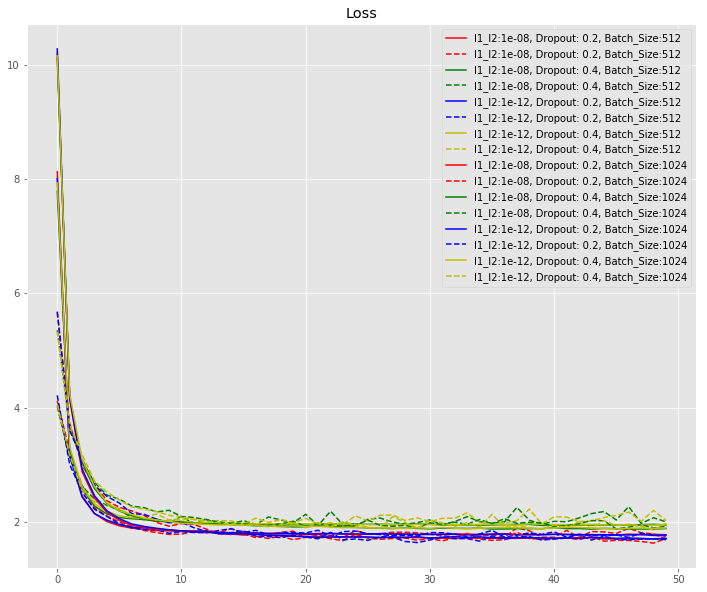

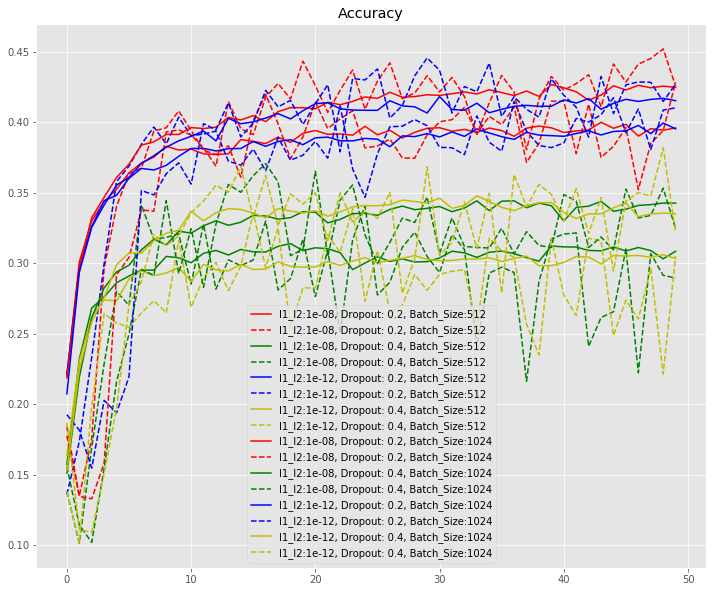

In [12]:
plt_model_result(results)